In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Dataset Model/archive/Dataset/Test"  # change to your folder path


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 8754 images belonging to 2 classes.
Found 2187 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  1/274 ━━━━━━━━━━━━━━━━━━━━ 2:51:09 38s/step - accuracy: 0.5000 - loss: 0.8001

In [ ]:
model.save("/content/drive/MyDrive/deepfake_classifier.h5")
print("Model Saved!")


In [ ]:
!pip install onnx onnxruntime keras2onnx

import keras2onnx
import onnx
from tensorflow.keras.models import load_model

model = load_model("deepfake_model.h5")
onnx_model = keras2onnx.convert_keras(model, model.name)

onnx.save_model(onnx_model, "deepfake_model.onnx")


In [ ]:
!pip install tensorflowjs

!tensorflowjs_converter \
    --input_format keras \
    /content/drive/MyDrive/deepfake_classifier.h5 \
    /content/drive/MyDrive/tfjs_model/


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/test.jpg"  # change this
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("FAKE")
else:
    print("REAL")


Model Loaded Successfully!
Found 2187 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 35s 326ms/step


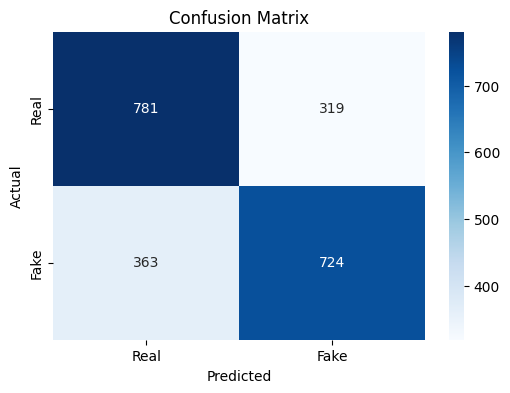

              precision    recall  f1-score   support

        Real       0.68      0.71      0.70      1100
        Fake       0.69      0.67      0.68      1087

    accuracy                           0.69      2187
   macro avg       0.69      0.69      0.69      2187
weighted avg       0.69      0.69      0.69      2187



In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------- 1. Load Saved Model --------
model = load_model("/content/drive/MyDrive/deepfake_classifier.h5")
print("Model Loaded Successfully!")

# -------- 2. Reload Dataset (same as before) --------
IMG_SIZE = 224
BATCH_SIZE = 32
dataset_path = "/content/drive/MyDrive/Dataset Model/archive/Dataset/Test"

datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# -------- 3. Get Predictions --------
val_gen.reset()
predictions = model.predict(val_gen)
pred_labels = (predictions > 0.5).astype(int)

# -------- 4. Get True Labels --------
true_labels = val_gen.classes

# -------- 5. Confusion Matrix --------
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# -------- 6. Classification Report --------
print(classification_report(true_labels, pred_labels, target_names=["Real", "Fake"]))
